# Water budget

$$
    \frac{\partial \int^{z=0}_{z=z_{bottom}}  \theta(z,t) dz}{\partial t} = (1-f_v) R + M_{snow} - E - R_{run} - R_{dra}     \tag{9.1}
$$

where $f_v$ is the fraction of rainfall ($R$) intercepeted by the surface reservoir and canopy, $M_{snow}$ is the snow melt, $R_{run}$ is the surface runoff, and $R_{dra}$ is the drainage. Furthermore $E$ is the evapotranspiration and can be devided into three components:

$$
    E = E_b + E_d + T_r    \tag{9.2}
$$

where $E_b$ is the evaporation from the bare soil, $E_d$ is the direct evaporation from the surface reservoir and canopy, and $T_r$ is transpiration.

<figure>
  <img src="../_static/images/water_budget_01.png" alt="Diagram of water budget in two soil layer LSM" style="width:100%">
  <figcaption>Figure 9.1. Diagram of water budget in two soil layer LSM.</figcaption>
</figure>



`````{warning}
- Many processes in water budget are still unkown.
<p style="margin: 0.5em 0;"></p>

- Many schemes for each process is parameterizeds based on very different assumptions and theories (concepts).
<p style="margin: 0.5em 0;"></p>

- Thus, we will:
    1) go through only a very simple scheme for each process
    2) build LSM by even further simplifying it
    3) neglect some processes, such as $M_{snow}$ and $E_d$
`````

<br>
<br>
<br>
<hr>

### Each componet of water budget

##### Precipitation ($R$)
- Water source of soil.
<p style="margin: 0.5em 0;"></p>

- Only for the top soil layer.
<p style="margin: 0.5em 0;"></p>

- Partioned into:
1) $f_v R$: interception by the surface reservior and canopy.
2) $(1-f_v) R$: water arrives at the land surface.
<p style="margin: 0.5em 0;"></p>

- Usually, $f_v$ is fixed at 0.25.

In [35]:
F_V  = 0.25

<br>
<br>
<hr>

##### Runoff ($R_{run}$) and Infilteration ($R_{inf}$)

- $(1-f_v) R$ is partitioned into $R_{run}$ and $R_{inf}$.
<p style="margin: 0.5em 0;"></p>

- Only for the top soil layer.
<p style="margin: 0.5em 0;"></p>

- Generally, $R_{inf}$ is determined first and then $R_{run}$ as a residual (or vice versa).
<p style="margin: 0.5em 0;"></p>

- We will employ {cite:p}`schaake1996simple` method {cite:p}`quichimbo2021dryp` and further simplify it:

$$
R_{inf}= \frac{(1-f_v) R I_c}{ (1-f_v) P + I_c}     \tag{9.3}
$$

where $I_c$ is given as

<br>

$$
I_c = (\theta_{sat} - \theta) (1 - \textrm{exp}(-k_{dt}))       \tag{9.4}
$$

where $k_{dt}$ is a constant that depends on soil hydraulic properties.

In [36]:
import numpy as np
import function_package as fp

In [37]:
K_DT = 0.010

def calculate_infiltration(theta, rain_at_surface):
    Ic = (fp.THETA_SAT - theta) * (1 - np.exp(-K_DT))

    return rain_at_surface * Ic / (rain_at_surface + Ic)

def calculate_runoff(rain_at_surface, infiltration):
    return rain_at_surface - infiltration

In [38]:
# Setup

rain_mm_day  = 30.0    # mm/day
rain  = rain_mm_day / 86400.0 # mm/s

rain_at_surface = rain * (1 - F_V)

theta = np.arange(fp.THETA_PWP, fp.THETA_SAT, 0.001) # m3/m3


infiltration = calculate_infiltration(theta, rain_at_surface)
runoff       = calculate_runoff(rain_at_surface, infiltration)

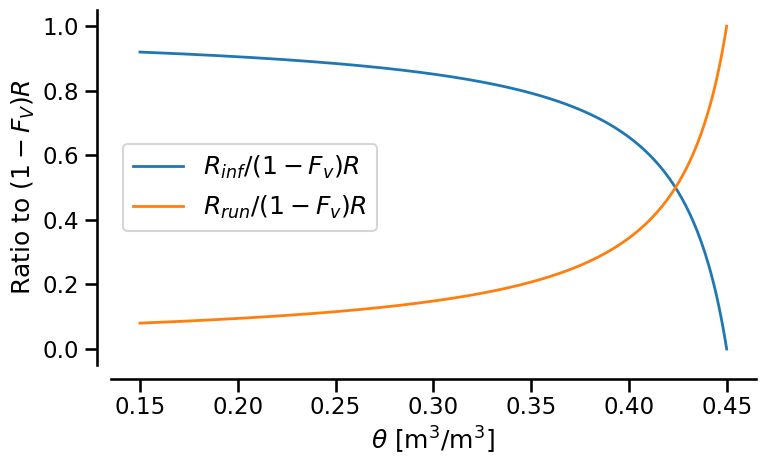

In [39]:
# plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(theta, infiltration/rain_at_surface, linewidth=2, label='$R_{inf} / (1 - F_v)R$')
ax.plot(theta, runoff/rain_at_surface,       linewidth=2, label='$R_{run} / (1 - F_v)R$')

ax.set_xlabel(r'$\theta$ [m$^{3}$/m$^{3}$]', fontsize=18)
ax.set_ylabel('Ratio to $(1-F_V)R$', fontsize=18)
ax.legend(fontsize=18)

sns.despine(offset=10)
plt.tight_layout()

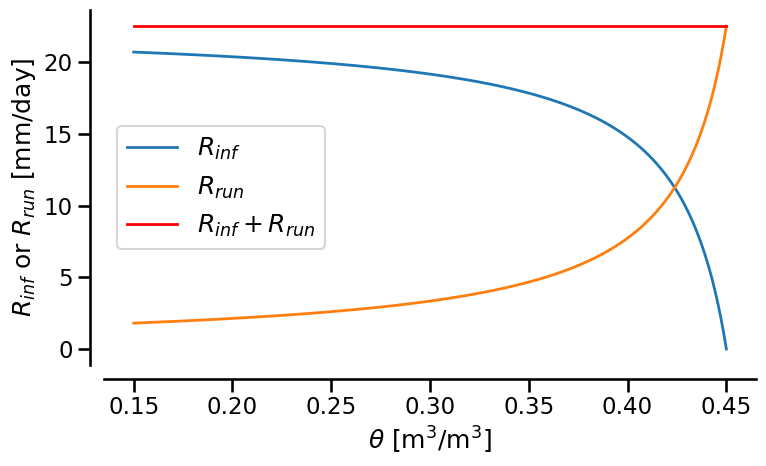

In [40]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(theta, infiltration * 86400., linewidth=2, label='$R_{inf}$')
ax.plot(theta, runoff * 86400.,       linewidth=2, label='$R_{run}$')
ax.plot(theta, runoff * 86400. + infiltration * 86400.,       linewidth=2, c='r', label='$R_{inf} + R_{run}$')

ax.set_xlabel(r'$\theta$ [m$^{3}$/m$^{3}$]', fontsize=18)
ax.set_ylabel('$R_{inf}$ or $R_{run}$ [mm/day]', fontsize=18)
ax.legend(fontsize=18)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<hr>

##### Evporation from the bare soil ($E_b$)

- Same as $\lambda E$, but

$$
E_b =  \textcolor{red}{(1-f_{veg})} \frac{\rho L_v (\beta q_{sat}(T_s, P_s) - q_a)}{r_h}        \tag{9.5}
$$

where $f_{veg}$ is the vegetation cover.

<br>

- Equivalent amount of the water should be extracted from the top soil.

<br>
<br>
<hr>

##### Transpiration ($T_r$)
- Same as $E_b$, but

$$
E_b =  \textcolor{red}{f_{veg}} \frac{\rho L_v (\textcolor{red}{q_{sat}(T_s, P_s)} - q_a)}{r_h + \textcolor{red}{r_s}}        \tag{9.6}
$$

where $r_s$ is the stomatal resistance, representign stomata opening of the leaf.



<figure>
  <img src="../_static/images/water_budget_02.png" style="width:50%">
</figure>


<br>

$r_s$ can be obtained as follow:


$$
\frac{1}{r_s} = f_{ws} \cdot LAI \cdot g_{s0}     \tag{9.7}
$$

where $LAI$ is leaf area index (m<sup>2</sup>/m<sup>2</sup>), $g_{s0}$ is a constant  and $f_{ws}$ is the water stress scaling facter:


$$
f_{ws} = 

\begin{cases}
0 & \text{for } \theta \le \theta_{pwp} \\
1 & \text{for } \theta \ge \theta_{fc} \\
\frac{\theta - \theta_{pwp}}{\theta_{fc} - \theta_{pwp}} & \text{otherwise } 
\end{cases}
$$
<!-- \tag{9.8} -->


`````{warning}
- Equivalent amount of the water should be extracted from root zone when we compute $\theta$.
`````


In [41]:
# Setup

F_VEG = 0.7
LAI   = 2.0   # m2/m2
G_S0  = 0.05  # m/s

In [42]:
def calculate_f_ws(theta):
    
    if theta <= fp.THETA_PWP:
        f_ws = 0.0
    elif theta >= fp.THETA_FC:
        f_ws = 1.0
    else:
        f_ws = (theta - fp.THETA_PWP) / (fp.THETA_FC - fp.THETA_PWP)

    return f_ws


def calculate_r_s(theta, LAI):

    f_ws = calculate_f_ws(theta)
    
    return 1/( np.maximum(f_ws, 1.0e-5) * LAI * G_S0 )

In [43]:
theta = np.arange(fp.THETA_PWP, fp.THETA_SAT, 0.001) # m3/m3

r_s = np.zeros(len(theta))

for i in np.arange(len(theta)):
    r_s[i] = calculate_r_s(theta[i], LAI)

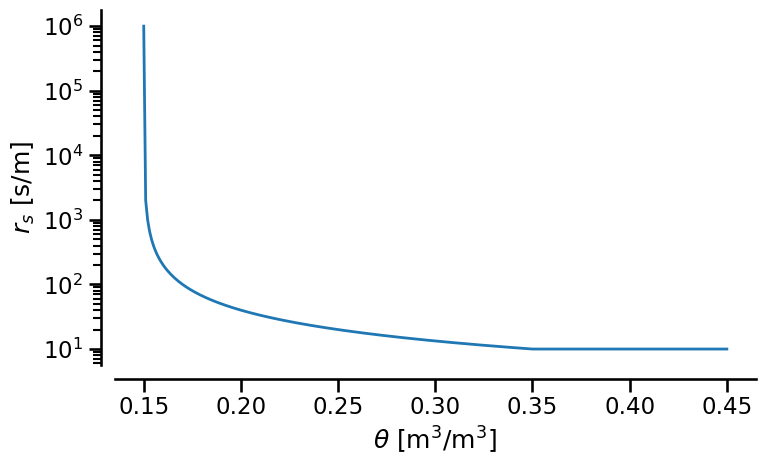

In [44]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(theta, r_s, linewidth=2)
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [m$^{3}$/m$^{3}$]', fontsize=18)
ax.set_ylabel('$r_s$ [s/m]', fontsize=18)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<hr>

##### Gravitational percolation ($R_{per}$)


$$
\frac{\partial \theta(k=1)}{\partial t} = ... - R_{per, 1-2}      \tag{9.9}
$$

$$
\frac{\partial \theta(k=2)}{\partial t} = ... + R_{per, 1-2}      \tag{9.10}
$$

`````{warning}
- Percolation between second soil layer and deeper soil is considered by $R_{dra}$.
`````

-  We will employ {cite:p}`van1980closed` scheme proposed by {cite:p}`disse1995modellierung` and further simplify it.


$$
R_{per} = \frac{\partial K}{\partial z}     \tag{9.11}
$$

where $K$ is the soil hydraulic conductivity. $K$ is function of $f_{ws}$:

$$
K = K_{sat} \sqrt{f_{ws}}       \tag{9.12}
$$

where $K_{sat}$ is $K$ at $\theta > \theta_{fc}$ and dependent on soil type.

In [45]:
# Take `SATDK` of LOAM soil type in SOILPARM.TBL
K_SAT = 3.38E-6   # m/s

In [46]:
def calculate_k(theta):
    
    f_ws = calculate_f_ws(theta)

    return K_SAT * np.sqrt(f_ws)

In [47]:
theta = np.arange(fp.THETA_PWP, fp.THETA_SAT, 0.001) # m3/m3

k = np.zeros(len(theta))

for i in np.arange(len(theta)):
    k[i] = calculate_k(theta[i])


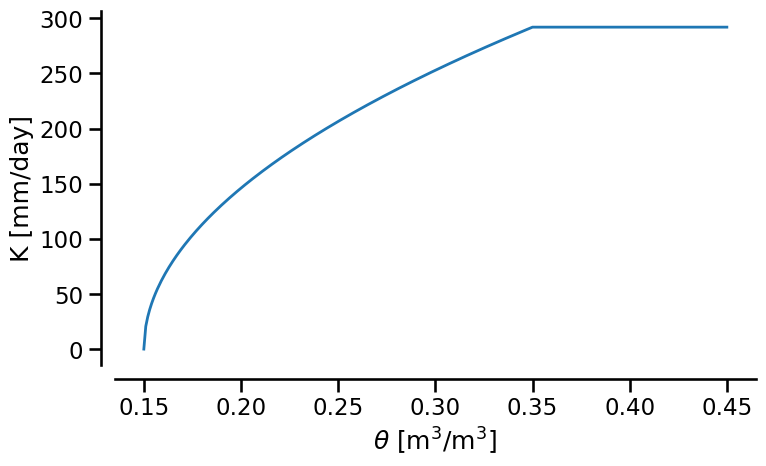

In [48]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(theta, k * 86400. * 1000., linewidth=2)

ax.set_xlabel(r'$\theta$ [m$^{3}$/m$^{3}$]', fontsize=18)
ax.set_ylabel('K [mm/day]', fontsize=18)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<hr>

##### Soil water diffusion ($D$)

$$
\frac{\partial \theta(k=1)}{\partial t} = ... - D_{1-2}      \tag{9.13}
$$

$$
\frac{\partial \theta(k=2)}{\partial t} = ... + D_{1-2}      \tag{9.14}
$$


`````{warning}
- Soil water diffusion between second soil layer and deeper soil is considered by $R_{dra}$.
`````

-  We will employ {cite:p}`clapp1978empirical` scheme and further simplify it.


$$
D = \frac{\partial}{\partial z} \left( D_{\theta} \frac{\partial \theta}{\partial z} \right)
$$


$$
D_{\theta} = b_{Clapp} K_{sat} \left(  \frac{\theta}{\theta_{sat}}  \right)^{3+b_{Clapp}}      \tag{9.15}
$$

where $b_{Clapp}$ is Clapp and Hornberger constant.

In [49]:
# Take `BB` of LOAM soil type in SOILPARM.TBL
B_CLAPP = 5.25

In [50]:
def calculate_d_theta(theta):
    
    k = calculate_k(theta)
    
    return B_CLAPP * K_SAT * (theta / fp.THETA_SAT)**(3 + B_CLAPP)

In [51]:
theta = np.arange(fp.THETA_PWP, fp.THETA_SAT, 0.001) # m3/m3

d_theta = np.zeros(len(theta))

for i in np.arange(len(theta)):
    d_theta[i] = calculate_d_theta(theta[i])


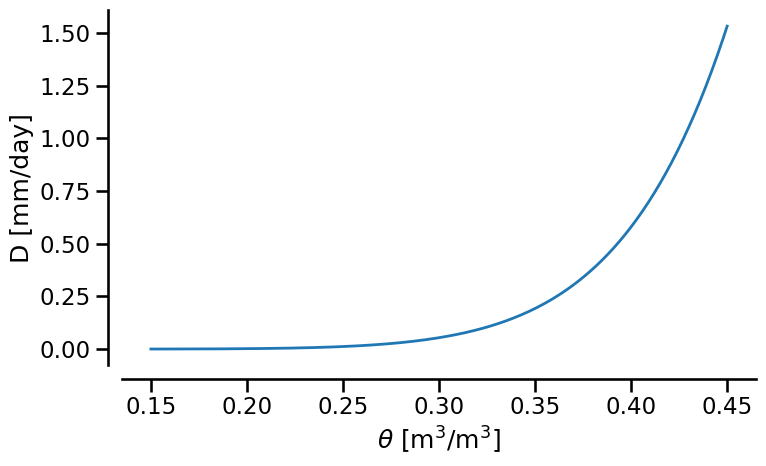

In [52]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(theta, d_theta * 86400., linewidth=2)

ax.set_xlabel(r'$\theta$ [m$^{3}$/m$^{3}$]', fontsize=18)
ax.set_ylabel('D [mm/day]', fontsize=18)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<br>
<hr>

##### Drainage ($R_{dra}$)

- Only for the bottom soil layer.
- We will employ {cite:p}`dumenil1992rainfall` scheme and further simplify it.

$$
R_{dra} = a_{min} \cdot f_{sat}       \tag{9.16}
$$

where $a_{min}$ is an constant and $f_{sat}$ is defined as,

$$
f_{sat} = 

\begin{cases}
0 & \text{for } \theta \le \theta_{pwp} \\
\frac{\theta - \theta_{pwp}}{\theta_{sat} - \theta_{pwp}} & \text{otherwise } 
\end{cases}         
$$

<!-- \tag{9.17} -->

In [53]:
A_MIN = 2.81 * 1.0e-7 * 1000. # mm/s

In [54]:
def calculate_f_sat(theta):
    
    if theta <= fp.THETA_PWP:
        f_sat = 0.0
    else:
        f_sat = (theta - fp.THETA_PWP) / (fp.THETA_SAT - fp.THETA_PWP)

    return f_sat

In [55]:
def calculate_drainage(theta):
    
    f_sat = calculate_f_sat(theta)
    
    return A_MIN * f_sat

In [56]:
theta = np.arange(fp.THETA_PWP, fp.THETA_SAT, 0.001) # m3/m3

drainage = np.zeros(len(theta))

for i in np.arange(len(theta)):
    drainage[i] = calculate_drainage(theta[i])


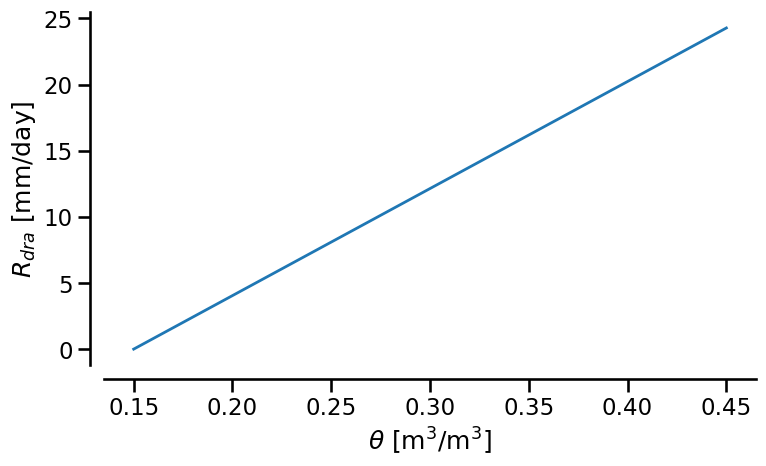

In [57]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(theta, drainage * 86400., linewidth=2)

ax.set_xlabel(r'$\theta$ [m$^{3}$/m$^{3}$]', fontsize=18)
ax.set_ylabel('$R_{dra}$ [mm/day]', fontsize=18)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<br>
<hr>

### Practice 9.1

Finally, predict $T_s$, $T_g$, and $\theta$ at Daegu ASOS station in April 2012 using observed atmospheric variables. Assume that

1) Observed variables contain $T_a$, $U$, & $SW_d$.
1) $z_r$ is 20 m
1) $z_0$ is 0.15 m
1) $T_s$ at initial time is set to observed $T_s$
1) $T_g(k=2)$ is initialized with $T_s-$ 0.2 K
1) $T_g(k=3)$ is fixed at $T_s-$ 0.5 K
1) $K_g$ is 1.0 W/m<sup>2</sup>/K
1) At initial time, $\theta(k=1)$ = 0.20 m<sup>3</sup>/m<sup>3</sup>, $\theta(k=2)$ = 0.25 m<sup>3</sup>/m<sup>3</sup>.
1) $C_{soil,1-2}$ and $C_{soil,2-3}$ are $c_{soil} \cdot \Delta z_{1-2}$ and $c_{soil} \cdot \Delta z_{2-3}$ ($c_s$ = 2.0 $\times$ 10<sup>6</sup> J/m<sup>3</sup>/K, $\Delta z_{1-2}$ is 0.07 m, and $\Delta z_{2-3}$ is 0.35 m
1) $\alpha$ is 0.3
1) $LW_d$ is 400 W/m<sup>2</sub>

&#8594; Now, fully predict the following Eqs, except for $SW_d$, $LW_d$, $M_{snow}$.

$$
C_{soil} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot SW_d + LW_d - LW_u - H - \lambda E - G       \tag{1.2}
$$

$$
    \frac{\partial \int^{z=0}_{z=z_{bottom}}  \theta(z)}{\partial z} = (1-f_v) R + M_{snow} - E - R_{run} - R_{dra}     \tag{9.1}
$$


In [58]:
import xarray as xr
import pandas as pd
import function_package as fp

In [63]:
# Setup
dt = 60 # s

# Make assumptions
LWd = 400       # W/m2
zr = 20.0 # height of the model lowest layer [m]
z0 = 0.15 # roughness length [m]

Z_12 = 0.07 # m
Z_23 = 0.35 # m

KG = 1.0 # W/m2/K
C_SOIL_1_2 = 2.0 * 1.0e6 * 0.07 # J/m2/K
C_SOIL_2_3 = 2.0 * 1.0e6 * 0.35 # J/m2/K

F_VEG = 0.7
LAI   = 2.0  # m2/m2

In [ ]:
# Get observation data
Ta, Ts, Pa, Qa, wind_speed, SWd, rho, R, ASOS_Daegu = fp.read_ASOS_at_Daegu('../data/ASOS_processed_2012033100-2012041000.nc', time_interval='1min')

In [61]:
# Predict Ts

time_dimension_size = len(Ts)

### Create an array for Ts
predicted_Ts  = np.zeros(time_dimension_size)
predicted_Tg2 = np.zeros(time_dimension_size)
predicted_Tg3 = np.zeros(time_dimension_size)
predicted_ust = np.zeros(time_dimension_size)
predicted_rh  = np.zeros(time_dimension_size)
predicted_H   = np.zeros(time_dimension_size)
predicted_LE  = np.zeros(time_dimension_size)
predicted_LWu = np.zeros(time_dimension_size)
predicted_G12 = np.zeros(time_dimension_size)
predicted_G23 = np.zeros(time_dimension_size)
predicted_q_sat = np.zeros(time_dimension_size)

predicted_theta1 = np.zeros(time_dimension_size)
predicted_theta2 = np.zeros(time_dimension_size)
predicted_infiltration = np.zeros(time_dimension_size)
predicted_runoff       = np.zeros(time_dimension_size)
predicted_Eb    = np.zeros(time_dimension_size)
predicted_Tr    = np.zeros(time_dimension_size)
predicted_LE    = np.zeros(time_dimension_size)
predicted_percolation_12 = np.zeros(time_dimension_size)
predicted_drainage       = np.zeros(time_dimension_size)
predicted_rain_at_surface = np.zeros(time_dimension_size)


### Initial value of Ts, Tg
predicted_Ts[0]  = Ts.isel(time=0).values
predicted_Tg2[0] = predicted_Ts[0] - 0.2
predicted_Tg3[:] = predicted_Ts[0] - 0.5
predicted_theta1[0] = 0.20
predicted_theta2[0] = 0.25

from tqdm import tqdm
for n in tqdm(np.arange(1, time_dimension_size), desc='Predicting surface temperature'):

    ### ①
    Rib = fp.calculate_bulk_richardson_number(predicted_Ts[n-1], Ta[n-1], Pa[n-1], wind_speed[n-1], zr)

    ### ②
    if Rib == 0.0:
        z_over_L = 0.0
    else:
        z_over_L = fp.calculate_z_over_L(Rib, zr, z0)

    ### ③
    z0_over_L  = z_over_L / zr * z0
    
    if Rib == 0.0:     # Neutral
        psi_m = 0.0
        psi_h = 0.0
    
    elif Rib > 0:      # Stable
        psi_m = fp.calculate_psim_stable(z_over_L) - fp.calculate_psim_stable(z0_over_L)
        psi_h = fp.calculate_psih_stable(z_over_L) - fp.calculate_psih_stable(z0_over_L)
    
    elif Rib < 0:      # Unstable
        psi_m = fp.calculate_psim_unstable(z_over_L) - fp.calculate_psim_unstable(z0_over_L)
        psi_h = fp.calculate_psih_unstable(z_over_L) - fp.calculate_psih_unstable(z0_over_L)

    ### ④
    zr_over_z0 = zr / z0
    ust = fp.KARMAN * wind_speed[n-1] / (np.log(zr_over_z0) - psi_m)
    predicted_ust[n] = ust

    ### ⑤
    rh = 1/(fp.KARMAN * ust) * ( np.log(zr_over_z0) - psi_h )
    predicted_rh[n] = rh

    ### ⑥
    H = rho[n-1] * fp.C_P * (predicted_Ts[n-1] - Ta[n-1]) / rh
    predicted_H[n] = H

    ### Evaporation & latent heat flux
    predicted_q_sat[n]  = fp.calculate_q_sat(predicted_Ts[n-1], fp.P_SFC)
    beta      = fp.calculate_moisture_availability(theta, Qa[n-1], predicted_q_sat[n])
    weighted_theta = (predicted_theta1[n-1] * Z_12 + predicted_theta2[n-1] * Z_23) / (Z_12 + Z_23)
    r_s       = calculate_r_s(weighted_theta, LAI)

    ### Bare soil evaporation & transpiration
    Eb        = (1-F_VEG) * (beta*predicted_q_sat[n] - Qa[n-1]) / rh          * rho[n-1]  # mm/s
    Tr        = F_VEG     * (     predicted_q_sat[n] - Qa[n-1]) / (rh + r_s)  * rho[n-1]  # mm/s

    ### Water extract by transpiration
    water_extract1 = Tr * Z_12/(Z_12 + Z_23) # mm/s
    water_extract2 = Tr * Z_23/(Z_12 + Z_23) # mm/s

    ### Runoff and infiltration
    rain_enters = R[n-1] / 3600 # from mm/hour to mm/s
    rain_at_surface = rain_enters * (1 - F_V)
    predicted_rain_at_surface[n] = rain_at_surface
    
    infiltration = calculate_infiltration(predicted_theta1[n-1], rain_at_surface)  # mm/s
    runoff       = calculate_runoff(rain_at_surface, infiltration)                 # mm/s
    predicted_runoff[n]       = runoff
    predicted_infiltration[n] = infiltration

    ### Percolation
    k_1 = calculate_k(predicted_theta1[n-1]) # m/s
    k_2 = calculate_k(predicted_theta2[n-1]) # m/s

    d_Z12_Z23 = (Z_12 + Z_23) / 2  # m
    percolation_12 = (k_1 - k_2) / ( d_Z12_Z23 ) # 1/s

    ### Drainage
    drainage = calculate_drainage(predicted_theta2[n-1]) # mm/s

    ### theta1
    predicted_theta1[n] = predicted_theta1[n-1] + dt/(1000.*Z_12) * (infiltration - Eb - water_extract1 - percolation_12)

    ### Check if theta1 is negative !!!!!
    if predicted_theta1[n] < 0.0:
        Eb             = 0.0
        water_extract1 = 0.0
        percolation_12 = 0.0
        predicted_theta1[n] = predicted_theta1[n-1]
    
    ### theta2
    predicted_theta2[n] = predicted_theta2[n-1] + dt/(1000.*Z_23) * (percolation_12 - water_extract2 - drainage)

    ### Check if theta2 is negative !!!!!
    if predicted_theta2[n] < 0.0:
        water_extract2 = 0.0
        drain          = 0.0
        predicted_theta2[n] = predicted_theta2[n-1]

    ### Update Transpiration
    Tr = water_extract1 + water_extract2

    ### Convert to latent heat flux
    LE = (Eb + Tr) * fp.LV  # W/m2

    predicted_Eb[n] = Eb
    predicted_Tr[n] = Tr
    predicted_LE[n] = LE
    predicted_percolation_12[n] = percolation_12
    predicted_drainage[n]       = drainage

    ### Ground heat flux
    G12 = KG * (predicted_Ts[n-1] - predicted_Tg2[n-1])  / Z_12
    predicted_G12[n] = G12
    G23 = KG * (predicted_Tg2[n-1] - predicted_Tg3[n-1]) / Z_23
    predicted_G23[n] = G23

    ### Upward longwave radiation
    LWu = fp.calculate_LWu(predicted_Ts[n-1])
    predicted_LWu[n] = LWu

    ### Surface & soil temperature
    predicted_Ts[n]  = predicted_Ts[n-1]  + dt/fp.C_SOIL_1_2 * ( (1-fp.ALBEDO) * SWd[n-1] + LWd - LWu - H - LE - G12 )
    predicted_Tg2[n] = predicted_Tg2[n-1] + dt/fp.C_SOIL_2_3 * ( G12 - G23 )


Predicting surface temperature: 100%|██████████| 5760/5760 [01:57<00:00, 48.91it/s] 


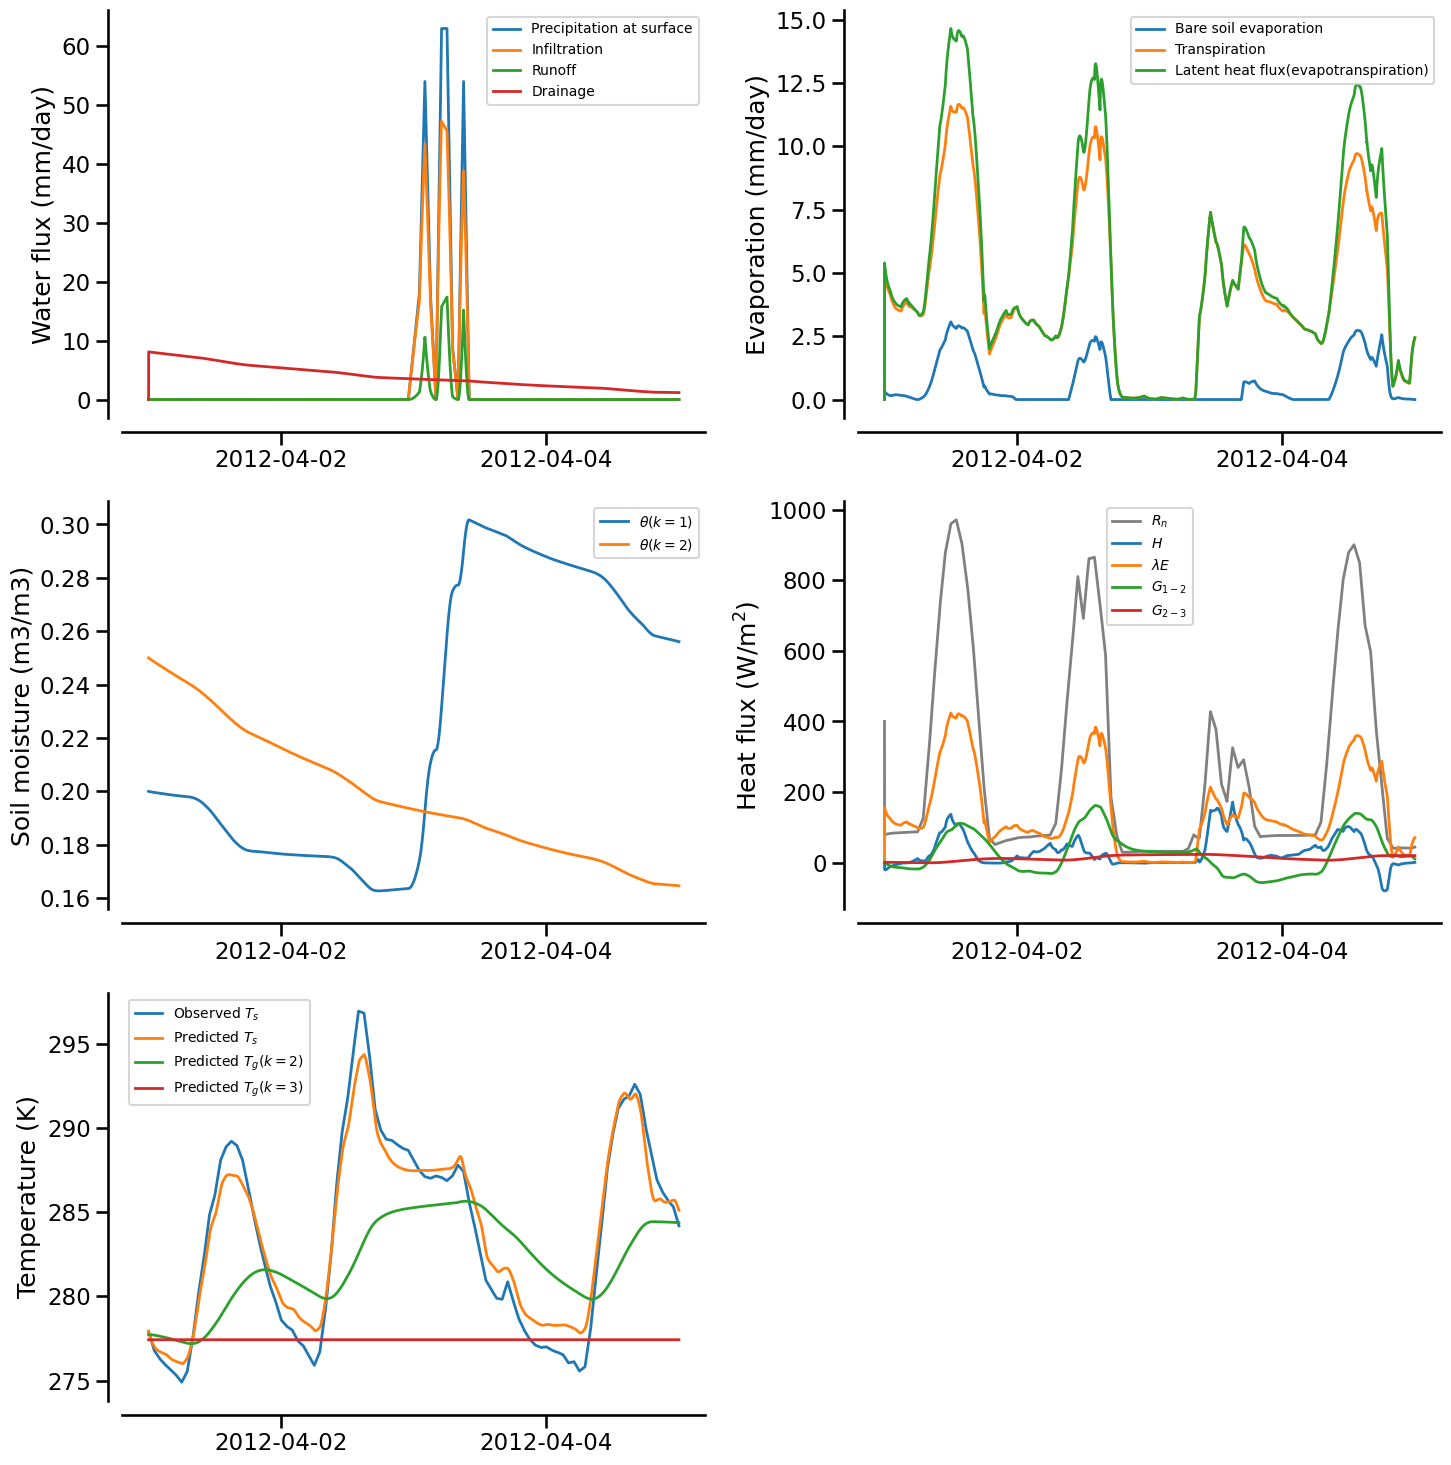

In [62]:
# plot

import matplotlib.dates as mdates

sns.set_context('talk')
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))

time_info = Ts['time'].values

### Precipitation at surface, infilteration, runoff
ax[0,0].plot(time_info, predicted_rain_at_surface*86400., linewidth=2, label='Precipitation at surface')
ax[0,0].plot(time_info, predicted_infiltration*86400., linewidth=2, label='Infiltration')
ax[0,0].plot(time_info, predicted_runoff*86400., linewidth=2, label='Runoff')
ax[0,0].plot(time_info, predicted_drainage*86400., linewidth=2, label='Drainage')
ax[0,0].set_ylabel('Water flux (mm/day)', fontsize=18)
ax[0,0].legend(fontsize=10)

### Evaporation
ax[0,1].plot(time_info, predicted_Eb * 86400, linewidth=2, label='Bare soil evaporation')
ax[0,1].plot(time_info, predicted_Tr * 86400, linewidth=2, label='Transpiration')
ax[0,1].plot(time_info, predicted_LE / fp.LV   * 86400., linewidth=2, label='Latent heat flux(evapotranspiration)')
ax[0,1].set_ylabel('Evaporation (mm/day)', fontsize=18)
ax[0,1].legend(fontsize=10)

### Surface temperature
ax[1,0].plot(time_info, predicted_theta1, linewidth=2, c='C0', label=r'$\theta(k=1)$')
ax[1,0].plot(time_info, predicted_theta2, linewidth=2, c='C1', label=r'$\theta(k=2)$')
ax[1,0].set_ylabel('Soil moisture (m3/m3)', fontsize=18)
ax[1,0].legend(fontsize=10)

### Heat flux
ax[1,1].plot(time_info, SWd+LWd-predicted_LWu,  linewidth=2,  c='gray', label=r'$R_n$')
ax[1,1].plot(time_info, predicted_H,  linewidth=2,  c='C0', label=r'$H$')
ax[1,1].plot(time_info, predicted_LE, linewidth=2,  c='C1', label=r'$\lambda E$')
ax[1,1].plot(time_info, predicted_G12, linewidth=2, c='C2', label=r'$G_{1-2}$')
ax[1,1].plot(time_info, predicted_G23, linewidth=2, c='C3', label=r'$G_{2-3}$')
ax[1,1].set_ylabel('Heat flux (W/m$^2$)', fontsize=18)
ax[1,1].legend(fontsize=10)

### Surface temperature
ax[2,0].plot(time_info, Ts,           linewidth=2, c='C0', label='Observed $T_s$')
ax[2,0].plot(time_info, predicted_Ts, linewidth=2, c='C1', label='Predicted $T_s$')
ax[2,0].plot(time_info, predicted_Tg2,linewidth=2, c='C2', label='Predicted $T_g(k=2)$')
ax[2,0].plot(time_info, predicted_Tg3,linewidth=2, c='C3', label='Predicted $T_g(k=3)$')
ax[2,0].set_ylabel('Temperature (K)', fontsize=18)
ax[2,0].legend(fontsize=10)


### properties
for i in range(3):
    for j in range(2):
        ax[i,j].xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax[2,1].set_visible(False)
sns.despine(offset=10)
plt.tight_layout()